# Анализ рынка видеоигр 

## Цели проекта 
- Выявить закономерности, определяющие успех игры
- Выявить потенциально популярный продукт 
- Составить портрет пользователя регионов Северной Америке, Европе и Японии
- Проверить гипотезы 
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    - Средние пользовательские рейтинги жанров Action и Sports разные

## План исследования 
- Определить цикл жизни плаформы 
- Определить актуальный период для анализа  
- Выявить лидеров продаж по платформам
- Выявить платформы находящихся в фазе роста
- Рассмотреть корелляцию между отзывами критиков и пользователей и продажами  
- Выявить лидеров продаж по жанрам
- Выявить жанры, находящиеся в фазе роста


## Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Данные с 1980 по 2016.

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from scipy import stats as st
import datetime

import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from IPython.display import display
%matplotlib inline 
#sns.set(color_codes=True)

from pylab import rcParams
rcParams['figure.figsize'] = 14, 12

In [2]:
games = pd.read_csv('')

In [3]:
games.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
6479,Dynasty Warriors 7: Xtreme Legends,PS3,2011.0,Action,0.04,0.04,0.16,0.02,64.0,7.8,T
12938,Taito Legends Power Up,PSP,2007.0,Action,0.05,0.00,0.00,0.00,41.0,tbd,E
16013,Dead Rising 2,XOne,2016.0,Action,0.01,0.00,0.00,0.00,NaN,tbd,M
10541,Metal Gear Solid HD Edition,PS3,2011.0,Action,0.00,0.00,0.10,0.00,NaN,NaN,NaN
2580,Guitar Hero: Aerosmith,PS2,2008.0,Misc,0.61,0.00,0.00,0.18,71.0,6.3,T


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Подготовка данных

User_Score (object) и Year_of_Release (float64) явно требуют преобразования.  

Приведу названия столбцов к нижнему регистру.

In [5]:
games.columns = map(str.lower, games.columns)

Посмотрим на пропущенные значения в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating


In [6]:
games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
games[games['name'].isnull()].index.tolist()

[659, 14244]

In [8]:
games[games['genre'].isnull()].index.tolist()

[659, 14244]

In [9]:
games.iloc[659]

name                NaN
platform            GEN
year_of_release    1993
genre               NaN
na_sales           1.78
eu_sales           0.53
jp_sales              0
other_sales        0.08
critic_score        NaN
user_score          NaN
rating              NaN
Name: 659, dtype: object

In [10]:
games.iloc[14244]

name                NaN
platform            GEN
year_of_release    1993
genre               NaN
na_sales              0
eu_sales              0
jp_sales           0.03
other_sales           0
critic_score        NaN
user_score          NaN
rating              NaN
Name: 14244, dtype: object

Посмотрим на пропущенные значения в year_of_release

In [11]:
games['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [63]:
games_null_year_of_release = pd.isnull(games['year_of_release']) 

У многих пропущенных значений в year_of_release, так же пропущенны critic_score, user_score, rating. 

Строки с пропусками в колонках Name, Genre, Year_of_Release удалю.

tbd в User_Score заменю на nan, чтобы иметь возможность работать со столбцом как с численным. 

Пропуски в User_Score, Critic_Score и Rating вероятно обусловлены тем, что у игры не было оценок, заполнять пропуски полагаю неправильным. 

In [13]:
games.dropna(subset=['name', 'genre', 'year_of_release'], inplace=True)

In [14]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')

Заменю значения tbd в user_score на пустые, этот столбец понадобится для анализа корреляции, посчитать которую возможно только с числовыми значениями. 

In [15]:
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format='%Y')
games['year_of_release'] = games['year_of_release'].dt.year 

In [16]:
games["user_score"] = pd.to_numeric(games["user_score"])

Проверю дубли 

In [17]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [18]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [19]:
games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,7983.000000,7463.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,68.994363,7.126330
std,5.875525,0.818378,0.506716,0.311100,0.188005,13.920060,1.499447
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


### Посчитаю суммарные продажи во всех регионах, добавив отдельный столбец 'world_sales'

In [20]:
games['world_sales'] = games['na_sales'] + games['eu_sales']+ games['jp_sales']+ games['other_sales']
games.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
5163,Nonomura Byoin no Hitobito,SAT,1996,Adventure,0.00,0.00,0.36,0.00,NaN,NaN,NaN,0.36
11318,Princess Isabella: A Witch's Curse,DS,2010,Adventure,0.05,0.03,0.00,0.01,NaN,NaN,E,0.09
7915,Tom Clancy's Splinter Cell: Blacklist,PC,2013,Action,0.04,0.13,0.00,0.01,82.0,7.4,M,0.18


## Выводы 

Общий дисклеймер — заполнение пропущенных значений в любых данных средними, медианными, модами видится мне неправильным, так как это влияет на статистиеские результаты. 

После предобработки данных у меня остались пропуски в critic_score, user_score, rating, заполнять которые полагаю неправильным, медианные значения сильно повлияют на статистические результаты. Пропуски в critic_score, user_score, rating вероятно обусловлены тем, что у игры не было оценок. 

У многих пропущенных значений в year_of_release, так же пропущенны critic_score, user_score, rating. 

# Исследовательский анализ данных

### Посмотрим сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


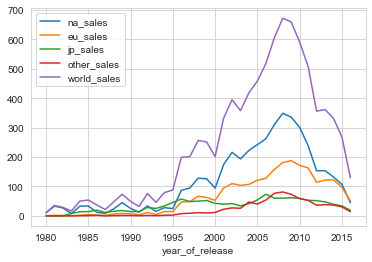

In [64]:
games[[x for x in games.columns if 'sales' in x] + ['year_of_release']].groupby('year_of_release').sum().plot();

### Вывод

Пик в 2008-2009 гг. Рост начинается с 2000. Самый емкий рынок — Северная Америка. 

Первый спад, после 2009 -- обусловлен мировым кризисом,  второй спад — в 2012, возможно, с развитием мобильного интернета и рынка мобильных игр.

### Посмотрим, как менялись продажи по платформам. 

### Посмотрим на распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

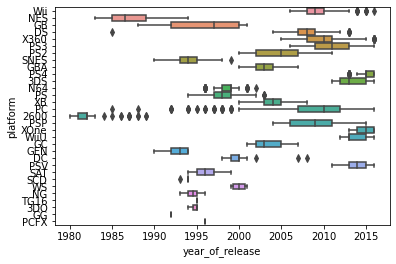

In [22]:
sns.boxplot(
      data=games,
      x=games['year_of_release'],
      y=games['platform']
      )
plt.show();

###  Вывод
Новые платформы повлятся, в среднем, раз в 10 лет. 

Оcновная доля игр появилась после 2000 года. 

### Оcновную часть прибыли платформа приносит 2-3-5 года, cделаю срез для актуальных данных 2011-2016.

In [23]:
games_5_years = games.query("2011 < year_of_release <= 2016") 

Создам словарь платформ, из уникальных значений столбца platform таблицы, срезанной с 2011-2016 годы. 

In [24]:
top_platforms_dict = games_5_years['platform'].unique()
top_platforms_dict

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

### Какие платформы лидируют по продажам, растут или падают? Выбираю несколько потенциально прибыльных платформ.

<AxesSubplot:xlabel='year_of_release'>

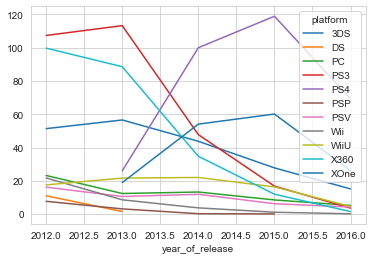

In [67]:
platform_grouped = pd.pivot_table(
     games_5_years,
     index="year_of_release",
     columns="platform",
     values="world_sales",
     aggfunc="sum"
 )

platform_grouped.plot()


В 2015 году c большим отрывом лидирует PS4, далее -- 3DS, XOne. Посмотрим объемы продаж по годам для платформ в словаре.

Далее рассмотрим прибыль по годам в разрезе платформ, чтобы определить растущие. 

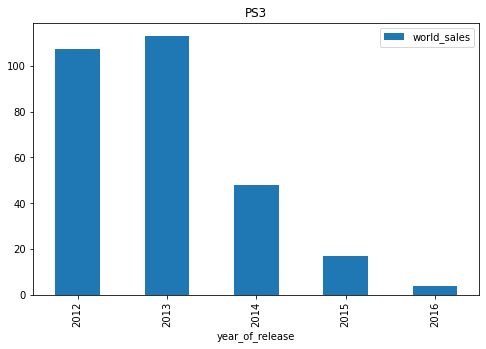

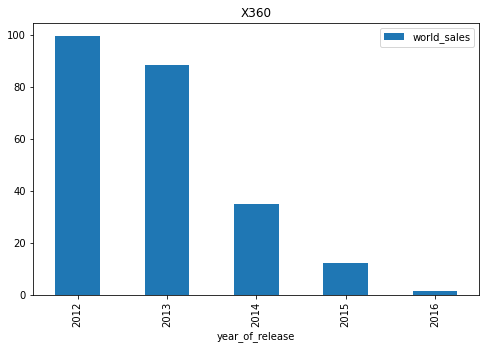

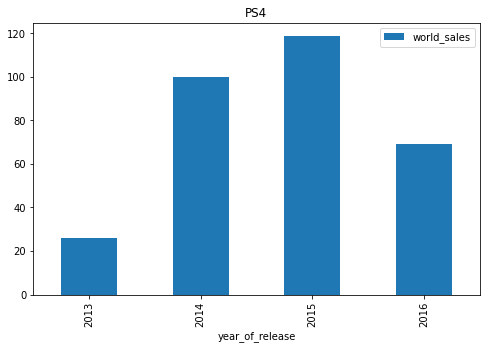

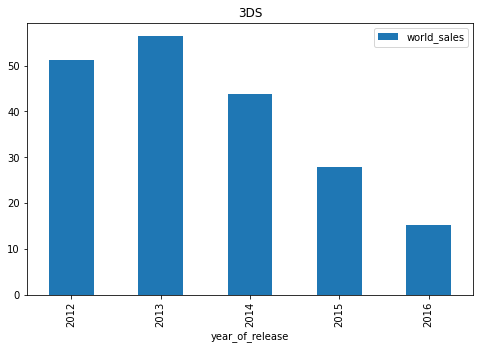

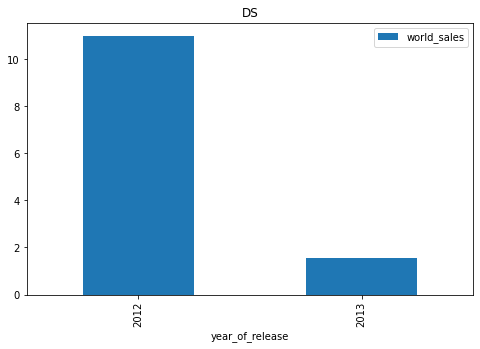

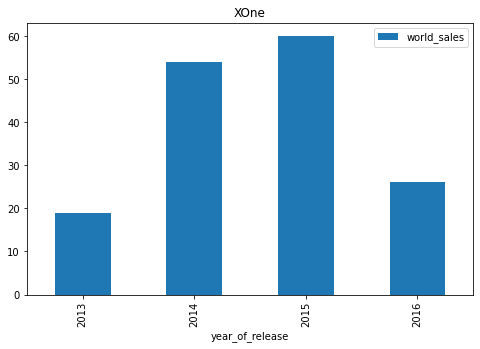

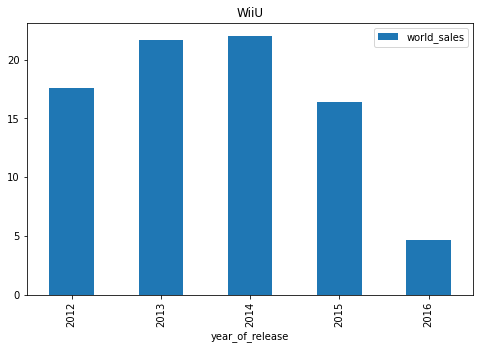

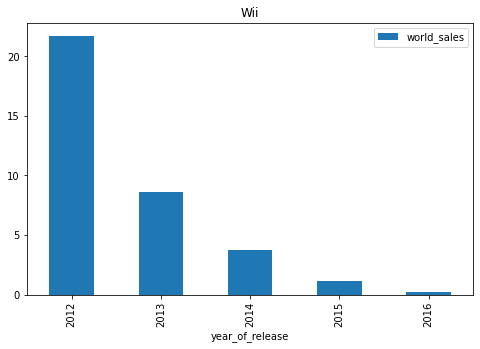

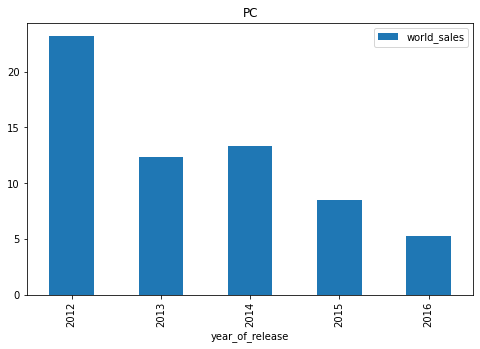

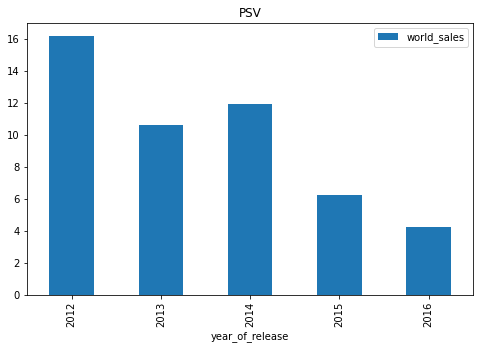

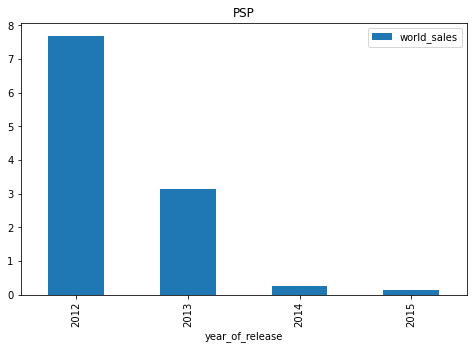

In [26]:
for platform in top_platforms_dict:
    games_5_years[games_5_years['platform'] == platform].pivot_table(index='year_of_release', values='world_sales', aggfunc='sum').plot(kind='bar', figsize=(8,5))
    figsize=(10, 16)
    plt.title(platform)

### Вывод

PS4 и XOne растут, соответственно, потенциально прибыльные платформы. 

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

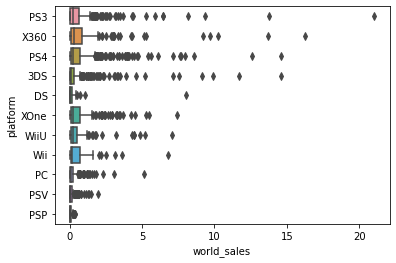

In [27]:
plt.ylim(0, 3)
ax = sns.boxplot(x="world_sales", y="platform", data=games_5_years)

### Вывод

Продажи соизмеримы у PS4 и XOne. 

Средние соизмеримы у XOne и X360. 

Следующий ранг вниз -- PS3 и Wii. 

## Как влияют на продажи отзывы пользователей и критиков на примере Xbox One

Cоздам срез для платформ XOne и PC. XOne понадобится сейчас в качестве одной из популярных платформ. PC чуть позже, для проверки гипотез. Создам срезы для платформ PS4, X360, PS3, Wii. 

In [28]:
XOne = games_5_years.query('platform in "XOne"')
PC = games_5_years.query('platform in "PC"')

PS4 = games_5_years.query('platform in "PS4"')
X360 = games_5_years.query('platform in "X360"')

PS3 = games_5_years.query('platform in "PS3"')
Wii= games_5_years.query('platform in "Wii"')

### Корреляция между отзывами критиков и продажами

In [29]:
print(XOne['critic_score'].corr(XOne['world_sales']))
print(X360['critic_score'].corr(X360['world_sales']))
print(PS4['critic_score'].corr(PS4['world_sales']))
print(PS3['critic_score'].corr(PS3['world_sales']))
print(Wii['critic_score'].corr(Wii['world_sales']))

print(games_5_years['critic_score'].corr(games_5_years['world_sales']))

0.41699832800840186
0.3605734888507336
0.40656790206178095
0.3314972592629587
-0.42434130110774954
0.308196745920778


### Корреляция между отзывами пользователей и продажами

In [30]:
print(XOne['user_score'].corr(XOne['world_sales']))
print(X360['user_score'].corr(X360['world_sales']))
print(PS4['user_score'].corr(PS4['world_sales']))
print(PS3['user_score'].corr(PS3['world_sales']))
print(Wii['user_score'].corr(Wii['world_sales']))

print(games_5_years['user_score'].corr(games_5_years['world_sales']))

-0.06892505328279414
0.006163978646213336
-0.03195711020455645
-0.005143522887113829
0.29619680007479526
0.004428817675493264


### Вывод

Коэфицент корреляции между продажами и оценкой критиков Xbox One -- 0.42. Иными словами, корреляция слабая. 

Аналогичные результаты показывают платформы PS4, X360, PS3.

Платформа Wii показывает отрицательну корреляцию. 

<AxesSubplot:xlabel='critic_score', ylabel='world_sales'>

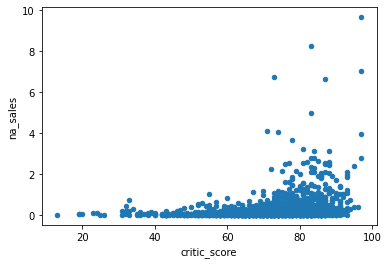

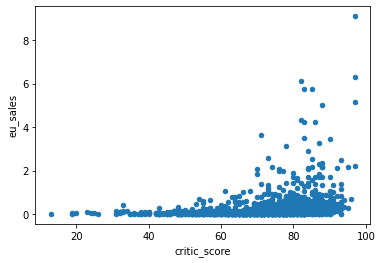

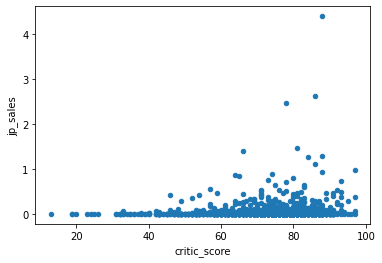

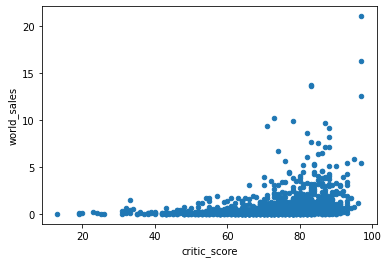

In [31]:
games_5_years.plot(x='critic_score', y='na_sales', kind='scatter')
games_5_years.plot(x='critic_score', y='eu_sales', kind='scatter')
games_5_years.plot(x='critic_score', y='jp_sales', kind='scatter')
games_5_years.plot(x='critic_score', y='world_sales', kind='scatter')

### Посмотрим на распределение продаж в мире в зависимости от отзывов пользователей


<AxesSubplot:xlabel='critic_score', ylabel='world_sales'>

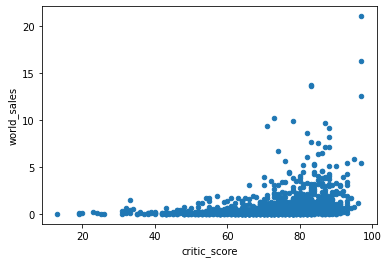

In [32]:
games_5_years.plot(x='critic_score', y='world_sales', kind='scatter')

In [33]:
games_5_years.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_release,2886.0,2013.916840,1.411766,2012.00,2013.00,2014.00,2015.00,2016.00
na_sales,2886.0,0.204771,0.566696,0.00,0.00,0.03,0.17,9.66
eu_sales,2886.0,0.175613,0.505346,0.00,0.00,0.03,0.14,9.09
jp_sales,2886.0,0.066729,0.241575,0.00,0.00,0.01,0.05,4.39
other_sales,2886.0,0.054109,0.164639,0.00,0.00,0.01,0.04,3.96
critic_score,1312.0,72.258384,12.687087,13.00,66.00,74.00,81.00,97.00
user_score,1531.0,6.636120,1.569033,0.20,5.80,7.00,7.80,9.30
world_sales,2886.0,0.501223,1.249157,0.01,0.04,0.12,0.43,21.05


In [34]:
games_5_years['user_score'].median() 

7.0

In [35]:
games_5_years['critic_score'].median() 

74.0

### Вывод

#### Влияние оценок пользователей — корреляция слабая 

Плотность выше у оценок пользователей с 7 до 8. 50%—75% значений лежат в интервале 7.0—7.8. Средняя — 6.63, медиана — 7. 

Поскольку корреляция между 'user_score' и 'world_sales' = 0.01 и распределение не имеет ярко выраженных иных групп, кроме как скопления между 7—8, я бы сделала вывод, что для успешности игры достаточно получить оценку = 7, для прибыли чуть выше — необходима оценка выше 7.8.

#### Влияние оценок критиков — корреляция слабая

Плотность выше у оценок критиков около отметки = 80. 50%—75% значений лежат в интервале 74—81. Средняя — 72, медиана — 74. 

Поскольку корреляция между 'critic_score' и 'world_sales' = 0.3 и распределение не имеет ярко выраженных иных групп, кроме как скопления между около отметки = 80, я бы сделала вывод, что для успешности игры достаточно получить оценку = 74, для прибыли чуть выше — необходима оценка выше 81.


### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

<AxesSubplot:xlabel='genre', ylabel='world_sales'>

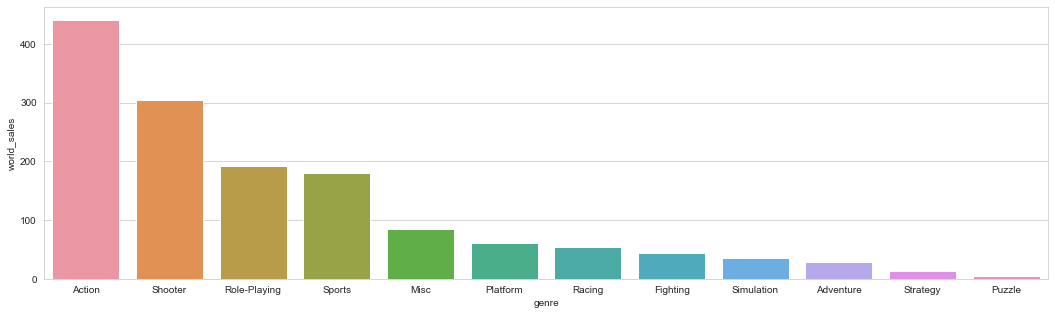

In [36]:
genre_grouped = games_5_years.pivot_table(index=['genre'], values='world_sales', aggfunc='sum').reset_index().sort_values(by='world_sales', ascending=False)

genre_dict = genre_grouped['genre'].unique()

sns.set_style('whitegrid')
plt.figure(figsize=(18, 5))
sns.barplot(data = genre_grouped, x='genre', y='world_sales')

Посмотрим на распределение продаж и оценок критиков и пользователей по жанрам

In [37]:
games_5_years.groupby('genre').median().head(12)

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,world_sales
genre,,,,,,,,
Action,2014.0,0.02,0.020,0.01,0.01,73.0,7.10,0.120
Adventure,2014.0,0.00,0.000,0.01,0.00,72.0,7.55,0.030
Fighting,2014.0,0.05,0.020,0.03,0.01,74.0,7.40,0.130
Misc,2014.0,0.01,0.015,0.02,0.00,75.0,7.00,0.120
Platform,2013.0,0.09,0.080,0.00,0.02,78.0,7.20,0.210
Puzzle,2013.5,0.00,0.010,0.00,0.00,71.0,7.90,0.045
Racing,2014.0,0.04,0.090,0.00,0.02,75.0,6.30,0.140
Role-Playing,2014.0,0.02,0.010,0.06,0.01,74.0,7.50,0.140
Shooter,2014.0,0.20,0.170,0.00,0.05,76.0,6.70,0.440


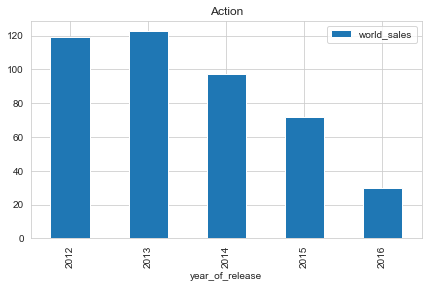

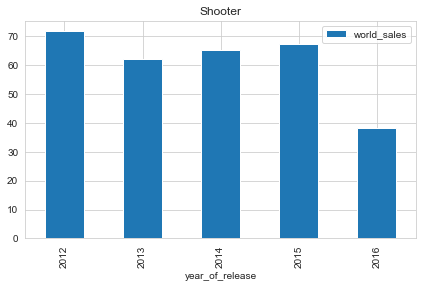

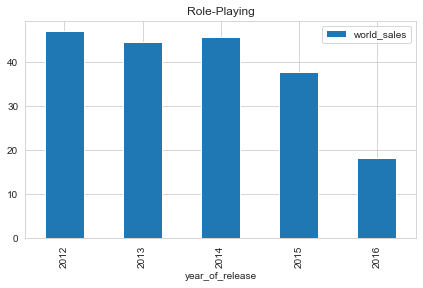

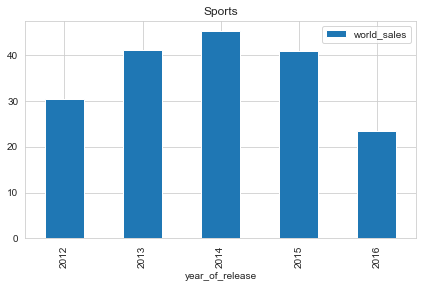

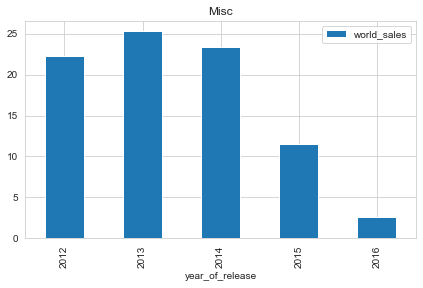

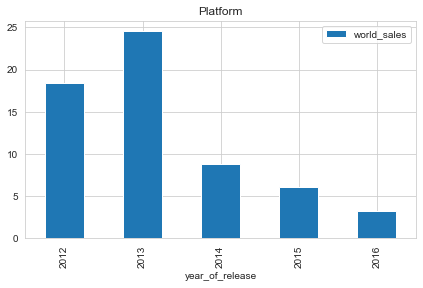

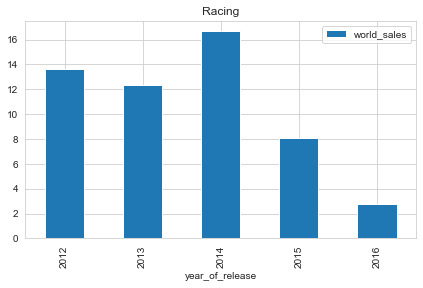

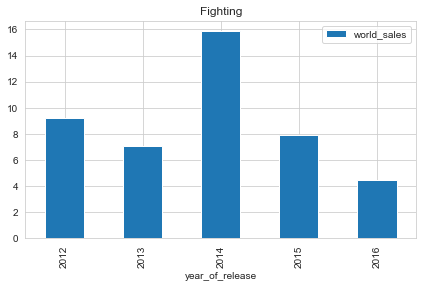

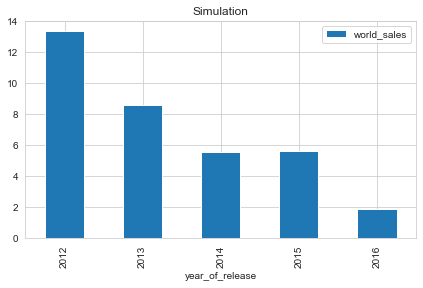

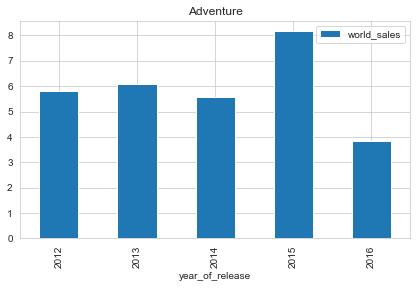

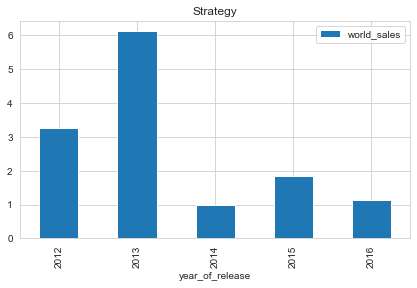

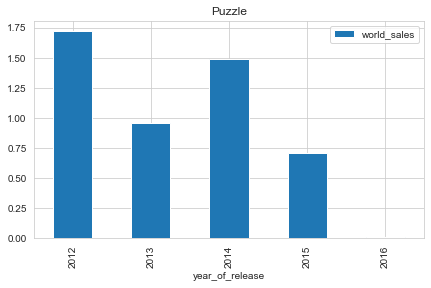

In [38]:
for genre in genre_dict:
    games_5_years[games_5_years['genre'] == genre].pivot_table(index='year_of_release', values='world_sales', aggfunc='sum').plot(kind='bar', figsize=(7,4))
    plt.title(genre) 

### Выводы

Прибыльность жанров в порядке убывания
- Action
- Shooter
- Role-Playing
- Sports
- Misc
- Platform
- Racing
- Fighting
- Simulation
- Adventure
- Strategy
- Puzzle

Возрастающй тренд у Shooter, Simulation, Adventure и Strategy. Puzzle наименее популярный жанр. 

# Портрет пользователя регионов Северной Америке, Европе и Японии

### Самые популярные платформы

In [39]:
games_5_years.pivot_table(['na_sales'], ['platform'], aggfunc='sum').sort_values(by = "na_sales", ascending = False).head(5)

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


In [40]:
games_5_years.pivot_table(['eu_sales'], ['platform'], aggfunc='sum').sort_values(by = "eu_sales", ascending = False).head(5)

,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64


In [41]:
games_5_years.pivot_table(['jp_sales'], ['platform'], aggfunc='sum').sort_values(by = "jp_sales", ascending = False).head(5)

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


### Вывод

X360, с существенным отрывом, занимает первое место в Северной Америке и третье в Европе. Так же в лидерах PS3 и PS4. 

Ожидаемо, что Япония имеет свои предпотения по платформам 3DS, PS3, PSV, WiiU, PSP.

### Самые популярные жанры


In [42]:
games_5_years.pivot_table(['na_sales'], ['genre'], aggfunc='sum').sort_values(by = "na_sales", ascending = False).head(5)

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


In [43]:
games_5_years.pivot_table(['eu_sales'], ['genre'], aggfunc='sum').sort_values(by = "eu_sales", ascending = False).head(5)

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


In [44]:
games_5_years.pivot_table(['jp_sales'], ['genre'], aggfunc='sum').sort_values(by = "jp_sales", ascending = False).head(5)

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


### Вывод

Среди популярных жанров Северной Америке и Европы -- Action, Shooter, Sports, Role-Playing, Misc.

В Японии другая пятерка лидеров -- Role-Playing, Action, Misc, Simulation, Fighting.

### Посмотрим на наиболее продаваемые в мире рейтинги

<AxesSubplot:xlabel='rating', ylabel='world_sales'>

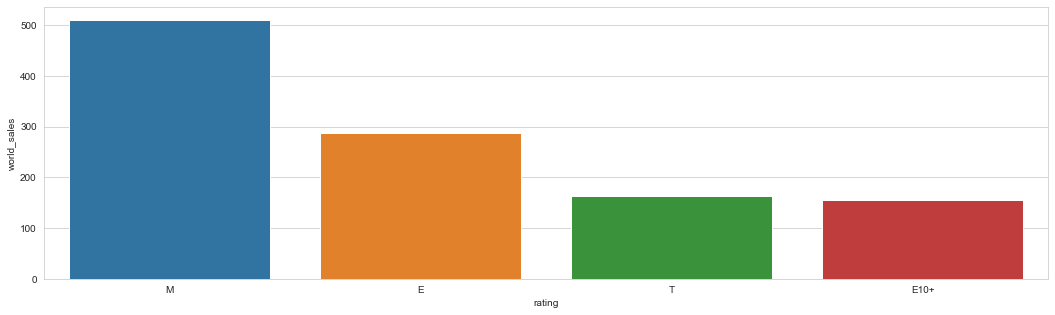

In [45]:
rating = games_5_years.pivot_table(index=['rating'], values='world_sales', aggfunc='sum').reset_index().sort_values(by='world_sales', ascending=False)
 
sns.set_style('whitegrid')
plt.figure(figsize=(18, 5))
sns.barplot(data = rating, x='rating', y='world_sales')

Зачения, согласно https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board#%D0%94%D0%B5%D0%B9%D1%81%D1%82%D0%B2%D1%83%D1%8E%D1%89%D0%B8%D0%B5

- «M» («Mature») — «Для взрослых»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»

Посмотрим, совпадают ли вкусы народов мира

<AxesSubplot:xlabel='rating', ylabel='na_sales'>

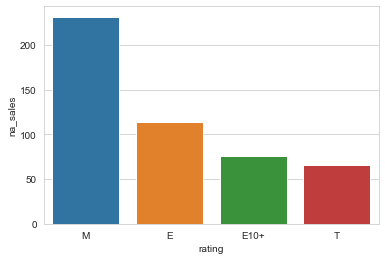

In [46]:
na_sales = games_5_years.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False)

sns.barplot(data = na_sales, x='rating', y='na_sales')

<AxesSubplot:xlabel='rating', ylabel='eu_sales'>

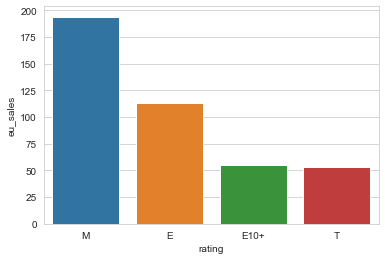

In [47]:
eu_sales = games_5_years.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False)

sns.barplot(data = eu_sales, x='rating', y='eu_sales')

<AxesSubplot:xlabel='rating', ylabel='jp_sales'>

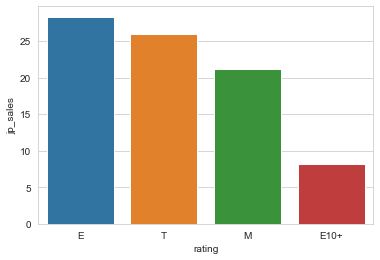

In [48]:
jp_sales = games_5_years.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False)

sns.barplot(data = jp_sales, x='rating', y='jp_sales')

### Вывод

Популярные рейтинги Северной Америке и в Европе в порядке убывания -- «Для взрослых», «Для всех», Для всех от 10 лет и старше». 

В Японии другая пятерка лидеров -- «Для всех», «Подросткам», «Для взрослых».

# Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

### Проверим гипотезу о равенстве средних пользовательских рейтингов «Xbox» и «PC»: 

- 𝐻0: средние в двух выборках равны (Xbox == PC)
- 𝐻1: средние в двух выборках не равны (Xbox != PC)

Делаю 2 выборки. 
Устанавливаю критический уровень статистической значимости p-value < 𝛼=0.05, так как это сдандарт для экономических расчетов. 

In [49]:
Xbox = games.query('platform in "XOne"')
PC = games.query('platform in "PC"')

Xbox_user_score = Xbox["user_score"].dropna()
PC_user_score = PC["user_score"].dropna()

Посмотрим на распределения

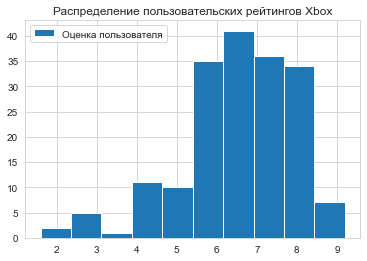

In [50]:
ax = Xbox_user_score.hist(label='Xbox');
ax.set_title("Распределение пользовательских рейтингов Xbox");
ax.legend(['Оценка пользователя']);

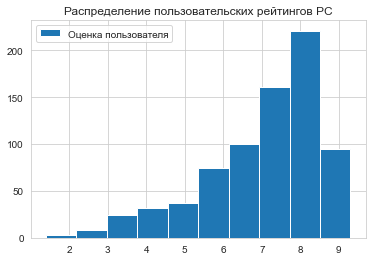

In [51]:
ax = PC_user_score.hist(label='PC');
ax.set_title("Распределение пользовательских рейтингов PC");
ax.legend(['Оценка пользователя']);

Проверяем гипотезу о равных дисперсиях двух выборок в соответствии с критерием Левене для проведения теста Т-Стьюдента

- 𝐻0: дисперсии в двух выборках равны (Xbox_user_score== PC_user_score)
- 𝐻1: дисперсии в двух выборках не равны (Xbox_user_score != PC_user_score)

In [52]:
from scipy.stats import levene
levene(Xbox_user_score, PC_user_score)

LeveneResult(statistic=1.1706180824505048, pvalue=0.2795532372785057)

In [53]:
alpha = 0.05
pvalue= 0.2795532372785057

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу о равных дисперсиях")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равных дисперсиях")

Не получилось отвергнуть нулевую гипотезу о равных дисперсиях


Использую непараметрический критерий Манна Уитни, так как оба распределения ненормальные, с выборосами.

In [54]:
from scipy.stats import mannwhitneyu
mannwhitneyu(Xbox_user_score, PC_user_score)[1]

4.955110511953333e-09

In [55]:
alpha = 0.05
pvalue= 4.955110511953333e-09

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу о равных средних")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу о равных средних


### Проверим гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports: 

- 𝐻0: средние в двух выборках равны (Action == Sports)
- 𝐻1: средние в двух выборках не равны (Action != Sports)

Делаю 2 выборки. 
Устанавливаю критический уровень статистической значимости p-value < 𝛼=0.05, так как это сдандарт для экономических расчетов. 

In [56]:
action = games.query('genre in "Action"')
sports = games.query('genre in "Sports"')

action["user_score"] = pd.to_numeric(action["user_score"])
sports["user_score"] = pd.to_numeric(sports["user_score"])

action_user_score = action["user_score"].dropna()
sports_user_score = sports["user_score"].dropna()

Посмотрим на распределение

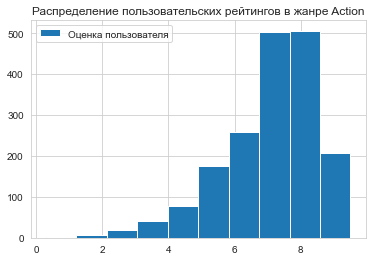

In [57]:
ax = action_user_score.hist(label='Action');
ax.set_title("Распределение пользовательских рейтингов в жанре Action");
ax.legend(['Оценка пользователя']);

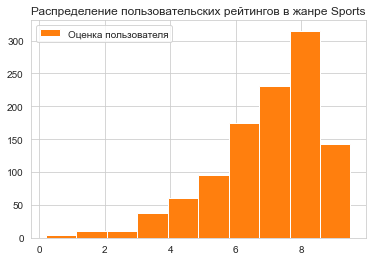

In [58]:
sports_user_score.hist();

ax = sports_user_score.hist(label='Sports');
ax.set_title("Распределение пользовательских рейтингов в жанре Sports");
ax.legend(['Оценка пользователя']);

Оба распределения скошенны влево. 

Проверим равенство дисперсий

In [59]:
levene(action_user_score, sports_user_score)

LeveneResult(statistic=15.429831733332641, pvalue=8.763985507235711e-05)

In [60]:
alpha = 0.05
pvalue= 8.763985507235711e-05

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу о равных дисперсиях")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равных дисперсиях")

Отвергаем нулевую гипотезу о равных дисперсиях


Использую непараметрический критерий Манна Уитни, так как оба распределения ненормальные, с выборосами.

In [61]:
mannwhitneyu(action_user_score, sports_user_score)[1]

0.28538882650312636

In [62]:
alpha = 0.05
pvalue= 0.28538882650312636

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу о равных средних")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


# Выводы

## Выводы сделаны по срезу за 5 лет — с 2011 по 2016 год


- Закономерности, определяющие успех игры: платформа, жанр, рейтинг. 
- У трех представленных регионов есть свои уникальные предпочтнения, следовательно, выбор платформы и жанра зависит от предполагаемого рынка сбыта.  
- Самый емкий рынок в Северной Америке. 


## Потенциально популярный продукт

Платформы
- PS4
- XOne 

Жанры
- Shooter
- Simulation
- Adventure
- Strategy

Рейтинг 
- «M» («Mature») — «Для взрослых»
- «E» («Everyone») — «Для всех»

#### У PS4 и XOne растут продажи, соответственно, это потенциально прибыльные платформы. 
Продажи соизмеримы у PS4 и XOne. Средние соизмеримы у XOne и X360. Следующий ранг вниз — PS3 и Wii. 

Платформы,  попавшие в пятилетку, актуальные на данный момент: PS3, X360, PS4, 3DS, DS, XOne, WiiU, Wii, PC, PSV, PSP.

Прибыльность жанров в порядке убывания:
* Action
* Shooter
* Role-Playing
* Sports
* Misc
* Platform
* Racing
* Fighting
* Simulation
* Adventure
* Strategy
* Puzzle

#### Возрастающй тренд у Shooter, Simulation, Adventure и Strategy. Puzzle наименее популярный жанр. 

#### Рейтиги в порядке убывания прибыльности:
- «M» («Mature») — «Для взрослых»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»



### Влияние оценок пользователей — корреляция слабая 

Плотность выше у оценок пользователей с 7 до 8. 50%—75% значений лежат в интервале 7.0—7.8. Средняя — 6.63, медиана — 7. 

Поскольку корреляция между 'user_score' и 'world_sales' = 0.01 и распределение не имеет ярко выраженных иных групп, кроме как скопления между 7—8, я бы сделала вывод, что для успешности игры достаточно получить оценку = 7, для прибыли чуть выше — необходима оценка выше 7.8.

### Влияние оценок критиков — корреляция слабая

Плотность выше у оценок критиков около отметки = 80. 50%—75% значений лежат в интервале 74—81. Средняя — 72, медиана — 74. 

Поскольку корреляция между 'critic_score' и 'world_sales' = 0.3 и распределение не имеет ярко выраженных иных групп, кроме как скопления между около отметки = 80, я бы сделала вывод, что для успешности игры достаточно получить оценку = 74, для прибыли чуть выше — необходима оценка выше 81.


## Портрет пользователя регионов Северной Америке, Европе и Японии

- X360, с существенным отрывом, занимает первое место в Северной Америке и третье в Европе. Так же в лидерах PS3 и PS4. 

- Ожидаемо, что Япония имеет свои предпочтения по платформам 3DS, PS3, PSV, WiiU, PSP.

- Среди популярных жанров Северной Америке и Европы — Action, Shooter, Sports, Role-Playing, Misc.

- В Японии другая пятерка лидеров — Role-Playing, Action, Misc, Simulation, Fighting.

- Популярные рейтинги Северной Америке и в Европе в порядке убывания — «Для взрослых», «Для всех», Для всех от 10 лет и старше». 

- В Японии другая пятерка лидеров — «Для всех», «Подросткам»,  «Для взрослых».

## Отвергаем гипотезу о равных средних пользовательских рейтингов «Xbox» и «PC». 

## Не получилось отвергнуть гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports. 